In [38]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from flavors.activate_function import ActivateFunctionController, ActivateFunctions

In [39]:
r_inside = 0.3
r_outside = 1

omega_inside = 20
omega_outside = 5

nu = 0.01

Z = 1
T = 1


class NavierStokesModel(nn.Module):
    def __init__(self):
        super(NavierStokesModel, self).__init__()

        self.activation_func = ActivateFunctionController(
            activate_func=ActivateFunctions.SiLUActivation, args=dict()
        ).get()

        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.activation_func(self.fc3(x))
        x = self.activation_func(self.fc4(x))
        return self.fc5(x)


model = NavierStokesModel()


def compute_pde(r_phi_z_t):
    r_phi_z_t.requires_grad_(True)
    up = model(r_phi_z_t)  # up is the output of the neural network: [u_r, u_theta, u_z, p]

    # Extract velocity components and pressure
    u_r, u_theta, u_z, p = up[:, 0], up[:, 1], up[:, 2], up[:, 3]

    # Compute gradients with respect to r, theta, z, and t
    r, theta, z, t = r_phi_z_t[:, 0], r_phi_z_t[:, 1], r_phi_z_t[:, 2], r_phi_z_t[:, 3]

    # Gradients for u_r
    u_r_r = torch.autograd.grad(u_r.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_r_theta = torch.autograd.grad(u_r.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_r_z = torch.autograd.grad(u_r.sum(), r_phi_z_t, create_graph=True)[0][:, 2]
    u_r_t = torch.autograd.grad(u_r.sum(), r_phi_z_t, create_graph=True)[0][:, 3]

    # Gradients for u_theta
    u_theta_r = torch.autograd.grad(u_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_theta_theta = torch.autograd.grad(u_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_theta_z = torch.autograd.grad(u_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 2]
    u_theta_t = torch.autograd.grad(u_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 3]

    # Gradients for u_z
    u_z_r = torch.autograd.grad(u_z.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_z_theta = torch.autograd.grad(u_z.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_z_z = torch.autograd.grad(u_z.sum(), r_phi_z_t, create_graph=True)[0][:, 2]
    u_z_t = torch.autograd.grad(u_z.sum(), r_phi_z_t, create_graph=True)[0][:, 3]

    # Gradients for pressure
    p_r = torch.autograd.grad(p.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    p_theta = torch.autograd.grad(p.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    p_z = torch.autograd.grad(p.sum(), r_phi_z_t, create_graph=True)[0][:, 2]

    # Second derivatives for u_r
    u_r_rr = torch.autograd.grad(u_r_r.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_r_theta_theta = torch.autograd.grad(u_r_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_r_zz = torch.autograd.grad(u_r_z.sum(), r_phi_z_t, create_graph=True)[0][:, 2]

    # Second derivatives for u_theta
    u_theta_rr = torch.autograd.grad(u_theta_r.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_theta_theta_theta = torch.autograd.grad(u_theta_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_theta_zz = torch.autograd.grad(u_theta_z.sum(), r_phi_z_t, create_graph=True)[0][:, 2]

    # Second derivatives for u_z
    u_z_rr = torch.autograd.grad(u_z_r.sum(), r_phi_z_t, create_graph=True)[0][:, 0]
    u_z_theta_theta = torch.autograd.grad(u_z_theta.sum(), r_phi_z_t, create_graph=True)[0][:, 1]
    u_z_zz = torch.autograd.grad(u_z_z.sum(), r_phi_z_t, create_graph=True)[0][:, 2]

    # Continuity equation in cylindrical coordinates
    continuity = (1 / r) * u_r_r + (1 / r) * u_theta_theta + u_z_z + (1 / r) * u_r

    # Momentum equations in cylindrical coordinates

    # Radial component (r-direction)
    momentum_r = (
        u_r_t
        + u_r * u_r_r
        + (u_theta / r) * u_r_theta
        - (u_theta**2) / r
        + u_z * u_r_z
        + (1 / r) * p_r
        - nu * (u_r_rr + (1 / r) * u_r_r - (u_r / r**2) + (1 / r**2) * u_r_theta_theta + u_r_zz - (2 / r**2) * u_theta_theta)
    )

    # Tangential component (theta-direction)
    momentum_theta = (
        u_theta_t
        + u_r * u_theta_r
        + (u_theta / r) * u_theta_theta
        + (u_r * u_theta) / r
        + u_z * u_theta_z
        + (1 / r) * p_theta
        - nu * (u_theta_rr + (1 / r) * u_theta_r - (u_theta / r**2) + (1 / r**2) * u_theta_theta_theta + u_theta_zz + (2 / r**2) * u_r_theta)
    )

    # Axial component (z-direction)
    momentum_z = (
        u_z_t
        + u_r * u_z_r
        + (u_theta / r) * u_z_theta
        + u_z * u_z_z
        + p_z
        - nu * (u_z_rr + (1 / r) * u_z_r + (1 / r**2) * u_z_theta_theta + u_z_zz)
    )

    return continuity, momentum_r, momentum_theta, momentum_z


def boundary_conditions():
    num_points = 1000
    t = T * np.random.random(num_points)
    r_outside_points = r_outside * np.ones(num_points)
    r_inside_points = r_inside * np.ones(num_points)

    outside_bc = torch.tensor(
        np.stack(
            [r_outside_points, np.random.uniform(0, 2 * np.pi, num_points), np.random.uniform(0, Z, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    inside_bc = torch.tensor(
        np.stack(
            [r_inside_points, np.random.uniform(0, 2 * np.pi, num_points), np.random.uniform(0, Z, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()

    outside_predict = model(outside_bc)
    inside_predict = model(inside_bc)
    
    u_r, u_theta, u_z, p = outside_predict[:, 0], outside_predict[:, 1], outside_predict[:, 2], outside_predict[:, 3]
    bc_loss = torch.mean((u_theta - omega_outside * r_outside)**2)

    u_r, u_theta, u_z, p = inside_predict[:, 0], inside_predict[:, 1], inside_predict[:, 2], inside_predict[:, 3]
    bc_loss += torch.mean((u_theta - omega_inside * r_inside)**2)


    
    return bc_loss


def generate_data(num_points):
    r = np.random.uniform(r_inside, r_outside, num_points)
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    z = np.random.uniform(0, Z, num_points)
    t = np.random.uniform(0, T, num_points)
    r_theta_z_t = np.stack([r, theta, z, t], axis=-1)
    return torch.tensor(r_theta_z_t, requires_grad=True).float()


def loss_function(xyt):
    continuity, momentum_r, momentum_theta, momentum_z = compute_pde(xyt)
    pde_loss = (
        torch.mean(continuity**2)
        + torch.mean(momentum_r**2)
        + torch.mean(momentum_theta**2)
        + torch.mean(momentum_z**2)
    )
    bc_loss = boundary_conditions()
    total_loss = pde_loss + bc_loss
    return total_loss


In [40]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000
num_points = 100
for epoch in range(num_epochs):
    r_phi_z_t = generate_data(num_points)
    optimizer.zero_grad()
    loss = loss_function(r_phi_z_t)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training completed.")


Epoch 0, Loss: 60.86670684814453
Epoch 100, Loss: 28.541255950927734
Epoch 200, Loss: 7.494790554046631
Epoch 300, Loss: 4.402867317199707
Epoch 400, Loss: 1.571747064590454
Epoch 500, Loss: 1.9675624370574951
Epoch 600, Loss: 0.8292924761772156
Epoch 700, Loss: 0.731831967830658
Epoch 800, Loss: 1.711280107498169
Epoch 900, Loss: 0.46018728613853455
Training completed.


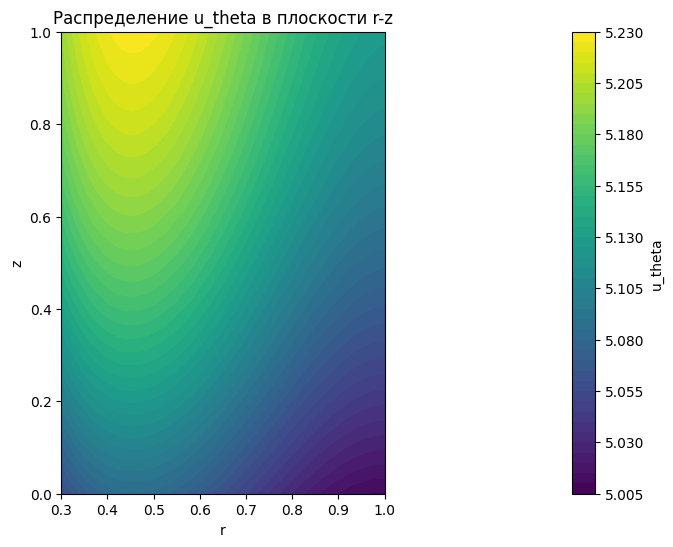

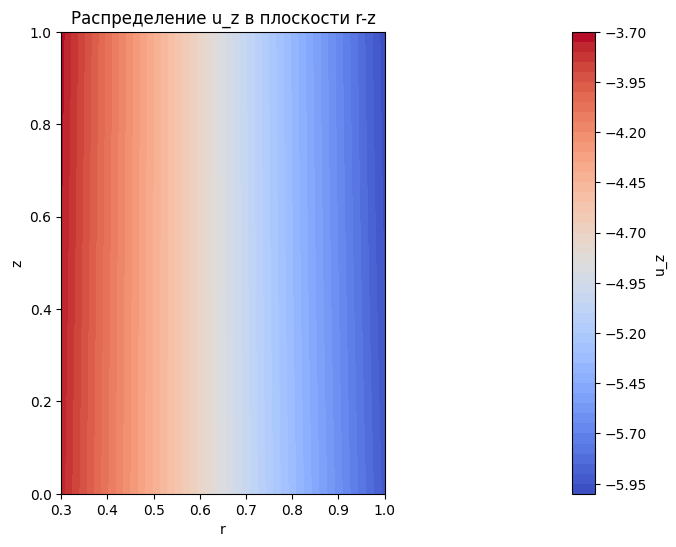

In [41]:

nr, ntheta, nz, nt = 5, 32, 5, 5

r = np.linspace(r_inside, r_outside, num_points)
z = np.linspace(0, Z, num_points)
t = np.linspace(0, T, num_points)

theta_fixed = 0.0

r_grid, z_grid = np.meshgrid(r, z, indexing='ij')
t_grid = np.full_like(r_grid, T / 2)
theta_grid = np.full_like(r_grid, theta_fixed)

grid = np.stack([r_grid.flatten(), theta_grid.flatten(), z_grid.flatten(), t_grid.flatten()], axis=-1)
tensor = torch.tensor(grid, requires_grad=False).float()

with torch.no_grad():
    predictions = model(tensor).numpy()

u_r = predictions[:, 0].reshape(r_grid.shape)
u_theta = predictions[:, 1].reshape(r_grid.shape)
u_z = predictions[:, 2].reshape(r_grid.shape)


plt.figure(figsize=(10, 6))
contour = plt.contourf(r_grid, z_grid, u_theta, levels=50, cmap='viridis')
plt.colorbar(contour, label='u_theta')

plt.xlabel('r')
plt.ylabel('z')
plt.title('Распределение u_theta в плоскости r-z')
plt.axis('scaled')
plt.show()

plt.figure(figsize=(10, 6))
contour = plt.contourf(r_grid, z_grid, u_z, levels=50, cmap='coolwarm')
plt.colorbar(contour, label='u_z')

plt.xlabel('r')
plt.ylabel('z')
plt.title('Распределение u_z в плоскости r-z')
plt.axis('scaled')
plt.show()

In [42]:
U_exact = np.tile(U / Ly * y, (nx)).reshape(nx, ny).T
V_exact = 0 * y[None, :] * x[:, None]


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].quiver(
    X, Y, U_exact, V_exact, scale=10, scale_units="xy"
)
axs[0].set_title(f"Velocity Vector Field (u, v)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

plt.tight_layout()
plt.show()

NameError: name 'U' is not defined

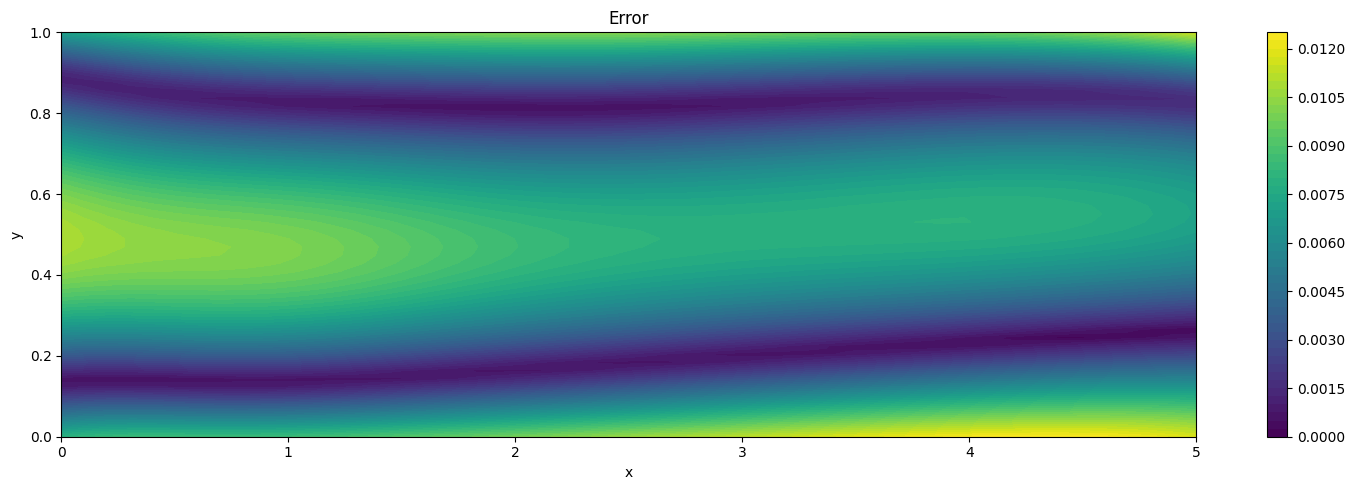

In [6]:
U_error = np.abs(U_exact - U_calc[:, :, 0])
V_error = np.abs(V_exact - V_calc[:, :, 0])

error = np.sqrt(U_error**2 + V_error**2)

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
c3 = axs.contourf(X, Y, error, levels=50, cmap="viridis")
axs.set_title("Error")
fig.colorbar(c3)
axs.set_xlabel("x")
axs.set_ylabel("y")

plt.tight_layout()
plt.show()